In [1]:
# importing the dependencies
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import gensim
import gensim.downloader
from nltk.tokenize import word_tokenize
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, SimpleRNN, Flatten, GlobalMaxPool1D
from collections import Counter
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.initializers import Constant

### Preprocessing the data 

In [2]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

train_df = train_df.drop(columns=['label-fine'])
test_df = test_df.drop(columns=['label-fine'])

# Creating developmental set of 500 rows from train set
train_df, dev_df = train_test_split(train_df, test_size=(500/len(train_df)), random_state=42)

counts = train_df['label-coarse'].value_counts()

# Find the labels with the lowest frequencies
lowest_frequency = [counts.index[-1], counts.index[-2]]
print("Labels being merged to new category: ", lowest_frequency)
print("Merged into new category: ", lowest_frequency[0])

# Replace these labels with new label: 6
train_df.loc[(train_df['label-coarse'].isin(lowest_frequency)), 'label-coarse'] = lowest_frequency[0]
dev_df.loc[(dev_df['label-coarse'].isin(lowest_frequency)), 'label-coarse'] = lowest_frequency[0]
test_df.loc[(test_df['label-coarse'].isin(lowest_frequency)), 'label-coarse'] = lowest_frequency[0]

train_df.reset_index(drop=True, inplace=True)
dev_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

Labels being merged to new category:  [2, 5]
Merged into new category:  2


In [3]:
train_df

,label-coarse,text
0,2,What is Mikhail Gorbachev 's middle initial ?
1,0,How does the tail affect the flight of a kite ?
2,2,What were the first three cities to have a pop...
3,1,What is the movie Jonathan Livingstone Seagull ?
4,1,What is a fear of home surroundings ?
...,...,...
4947,4,How much Coca Cola is drunk in one day in the ...
4948,2,What cathedral was Thomas Becket murdered in ?
4949,3,What character in The Beverly Hillbillies has ...
4950,2,What does the River Seine empty into ?


In [4]:
# Takes about ~30 mins for first run, ~30 seconds afterwards
word2vec = gensim.downloader.load('word2vec-google-news-300')

In [5]:
train_df['text'][0]

"What is Mikhail Gorbachev 's middle initial ?"

In [6]:
# Tokenize the text using word_tokenize
train_df['text'] = train_df['text'].apply(word_tokenize)
dev_df['text'] = dev_df['text'].apply(word_tokenize)
test_df['text'] = test_df['text'].apply(word_tokenize)

In [7]:
train_df['text'][0]

['What', 'is', 'Mikhail', 'Gorbachev', "'s", 'middle', 'initial', '?']

In [8]:
# Count total number of unique tokens in the training data 
unique_tokens = set()
train_df['text'].apply(unique_tokens.update)
# Remove words from the set which are not in the word2vec model
unique_tokens = unique_tokens.intersection(set(word2vec.key_to_index.keys()))
len(unique_tokens)

8170

In [9]:
tok = Tokenizer()
tok.fit_on_texts(train_df['text'])
train_df['text'] = tok.texts_to_sequences(train_df['text'])
dev_df['text'] = tok.texts_to_sequences(dev_df['text'])
test_df['text'] = tok.texts_to_sequences(test_df['text'])

In [10]:
train_df['text'][0]

[3, 4, 1435, 1091, 10, 461, 3214, 1]

In [11]:
X_train_sequences = train_df['text']
X_dev_sequences = dev_df['text']
X_test_sequences = test_df['text']

max_len = max([len(sentence) for sentence in train_df['text']])

# Pad sequences to a fixed length (if needed)
X_train_padded = pad_sequences(X_train_sequences, maxlen= max_len, padding='post', truncating='post')
X_dev_padded = pad_sequences(X_dev_sequences, maxlen=max_len, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_len, padding='post', truncating='post')

# Get the y labels
y_train = train_df['label-coarse']
y_dev = dev_df['label-coarse']
y_test = test_df['label-coarse']

# Convert the labels to categorical
y_train = to_categorical(y_train)
y_dev = to_categorical(y_dev)
y_test = to_categorical(y_test)

In [12]:
X_train_padded[0], y_train[0]

(array([   3,    4, 1435, 1091,   10,  461, 3214,    1,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0], dtype=int32),
 array([0., 0., 1., 0., 0.], dtype=float32))

In [13]:
embedding_dim = len(word2vec['apple']) # Any word vector dimensionality

In [14]:
# Create a dictionary with the unqiue_tokens with the tokens as keys and interger values as values
word_index = {}
for i, token in enumerate(unique_tokens):
    word_index[token] = i

In [15]:
vocab_size = len(word_index) + 1

In [16]:
embedding_matrix = np.zeros(shape=(vocab_size, embedding_dim))

for word, i in word_index.items():
    try:
        embedding_vector = word2vec[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        pass

In [17]:
num_epochs = [10, 20]
batch_sizes = [32, 64, 128]
learning_rates = [0.001]

In [19]:
# Perform hyperparameter optimization

class AccuracyCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        self.train_accuracies = []
        self.eval_accuracies = []
    
    def on_epoch_end(self, epoch, logs={}):
        self.train_accuracies.append(logs.get('accuracy'))
        self.eval_accuracies.append(logs.get('val_accuracy'))

accuracies = {}
test_accuracy = {}

for num_epoch in num_epochs:
    for batch_size in batch_sizes:
        for learning_rate in learning_rates:
            # Initialize the list to store the training and eval accuracies 
            accuracy_callback = AccuracyCallback()
            accuracies[(num_epoch, batch_size, learning_rate)] = accuracy_callback

            model = Sequential([
                Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len, embeddings_initializer=Constant(embedding_matrix), trainable=False),
                LSTM(512, return_sequences=True),
                Dropout(0.2),
                LSTM(128, return_sequences=True),
                Dropout(0.2),
                GlobalMaxPool1D(), 
                Dense(5, activation='softmax')
            ])

            # Train and store the accuracies
            optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
            model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
            model.fit(X_train_padded, y_train, epochs=num_epoch, batch_size=batch_size, validation_data=(X_dev_padded, y_dev), callbacks=[accuracy_callback])

            # Evaluate the model on the test data
            loss, accuracy = model.evaluate(X_test_padded, y_test)
            test_accuracy[(num_epoch, batch_size, learning_rate)] = accuracy

Epoch 1/10
155/155 [==============================] - 25s 154ms/step - loss: 1.1092 - accuracy: 0.5422 - val_loss: 0.9496 - val_accuracy: 0.6420
Epoch 2/10
155/155 [==============================] - 23s 146ms/step - loss: 0.8270 - accuracy: 0.6727 - val_loss: 0.8511 - val_accuracy: 0.6900
Epoch 3/10
155/155 [==============================] - 23s 146ms/step - loss: 0.7131 - accuracy: 0.7221 - val_loss: 0.7590 - val_accuracy: 0.7320
Epoch 4/10
155/155 [==============================] - 22s 141ms/step - loss: 0.6127 - accuracy: 0.7692 - val_loss: 0.6394 - val_accuracy: 0.7660
Epoch 5/10
155/155 [==============================] - 22s 141ms/step - loss: 0.5352 - accuracy: 0.7971 - val_loss: 0.5951 - val_accuracy: 0.7760
Epoch 6/10
155/155 [==============================] - 23s 146ms/step - loss: 0.4628 - accuracy: 0.8314 - val_loss: 0.5509 - val_accuracy: 0.7900
Epoch 7/10
155/155 [==============================] - 24s 153ms/step - loss: 0.3836 - accuracy: 0.8633 - val_loss: 0.5493 - val_ac

Epoch 1/10
78/78 [==============================] - 19s 222ms/step - loss: 1.1925 - accuracy: 0.5093 - val_loss: 0.9725 - val_accuracy: 0.6000
Epoch 2/10
78/78 [==============================] - 17s 224ms/step - loss: 0.8085 - accuracy: 0.6852 - val_loss: 0.7863 - val_accuracy: 0.7080
Epoch 3/10
78/78 [==============================] - 17s 224ms/step - loss: 0.6916 - accuracy: 0.7294 - val_loss: 0.7282 - val_accuracy: 0.7080
Epoch 4/10
78/78 [==============================] - 18s 225ms/step - loss: 0.6209 - accuracy: 0.7734 - val_loss: 0.6693 - val_accuracy: 0.7240
Epoch 5/10
78/78 [==============================] - 17s 223ms/step - loss: 0.5399 - accuracy: 0.8035 - val_loss: 0.6156 - val_accuracy: 0.7700
Epoch 6/10
78/78 [==============================] - 18s 226ms/step - loss: 0.4906 - accuracy: 0.8259 - val_loss: 0.5762 - val_accuracy: 0.7680
Epoch 7/10
78/78 [==============================] - 18s 235ms/step - loss: 0.4035 - accuracy: 0.8554 - val_loss: 0.5844 - val_accuracy: 0.7860

Epoch 1/10
39/39 [==============================] - 13s 307ms/step - loss: 1.2927 - accuracy: 0.4824 - val_loss: 1.0604 - val_accuracy: 0.5820
Epoch 2/10
39/39 [==============================] - 12s 298ms/step - loss: 0.8695 - accuracy: 0.6680 - val_loss: 0.8369 - val_accuracy: 0.6980
Epoch 3/10
39/39 [==============================] - 12s 299ms/step - loss: 0.7439 - accuracy: 0.7130 - val_loss: 0.7773 - val_accuracy: 0.7040
Epoch 4/10
39/39 [==============================] - 12s 300ms/step - loss: 0.6528 - accuracy: 0.7565 - val_loss: 0.7079 - val_accuracy: 0.7320
Epoch 5/10
39/39 [==============================] - 12s 305ms/step - loss: 0.5827 - accuracy: 0.7839 - val_loss: 0.6972 - val_accuracy: 0.7340
Epoch 6/10
39/39 [==============================] - 12s 309ms/step - loss: 0.5321 - accuracy: 0.8007 - val_loss: 0.6598 - val_accuracy: 0.7520
Epoch 7/10
39/39 [==============================] - 12s 308ms/step - loss: 0.4768 - accuracy: 0.8312 - val_loss: 0.6218 - val_accuracy: 0.7680

Epoch 1/20
155/155 [==============================] - 24s 147ms/step - loss: 1.0961 - accuracy: 0.5466 - val_loss: 0.9200 - val_accuracy: 0.6360
Epoch 2/20
155/155 [==============================] - 22s 141ms/step - loss: 0.8153 - accuracy: 0.6771 - val_loss: 0.8131 - val_accuracy: 0.6700
Epoch 3/20
155/155 [==============================] - 22s 144ms/step - loss: 0.7047 - accuracy: 0.7274 - val_loss: 0.7291 - val_accuracy: 0.7300
Epoch 4/20
155/155 [==============================] - 23s 146ms/step - loss: 0.5963 - accuracy: 0.7775 - val_loss: 0.6587 - val_accuracy: 0.7660
Epoch 5/20
155/155 [==============================] - 22s 140ms/step - loss: 0.5145 - accuracy: 0.8118 - val_loss: 0.6331 - val_accuracy: 0.7480
Epoch 6/20
155/155 [==============================] - 22s 141ms/step - loss: 0.4360 - accuracy: 0.8403 - val_loss: 0.6118 - val_accuracy: 0.7680
Epoch 7/20
155/155 [==============================] - 23s 146ms/step - loss: 0.3818 - accuracy: 0.8621 - val_loss: 0.5872 - val_ac

Epoch 1/20
78/78 [==============================] - 18s 211ms/step - loss: 1.1786 - accuracy: 0.5055 - val_loss: 0.9054 - val_accuracy: 0.6360
Epoch 2/20
78/78 [==============================] - 17s 217ms/step - loss: 0.8065 - accuracy: 0.6941 - val_loss: 0.7802 - val_accuracy: 0.6920
Epoch 3/20
78/78 [==============================] - 17s 220ms/step - loss: 0.6681 - accuracy: 0.7421 - val_loss: 0.6582 - val_accuracy: 0.7600
Epoch 4/20
78/78 [==============================] - 17s 224ms/step - loss: 0.5741 - accuracy: 0.7866 - val_loss: 0.6765 - val_accuracy: 0.7220
Epoch 5/20
78/78 [==============================] - 17s 220ms/step - loss: 0.5128 - accuracy: 0.8098 - val_loss: 0.5988 - val_accuracy: 0.7680
Epoch 6/20
78/78 [==============================] - 17s 217ms/step - loss: 0.4489 - accuracy: 0.8352 - val_loss: 0.6252 - val_accuracy: 0.7520
Epoch 7/20
78/78 [==============================] - 17s 219ms/step - loss: 0.4016 - accuracy: 0.8552 - val_loss: 0.5791 - val_accuracy: 0.7740

Epoch 1/20
39/39 [==============================] - 13s 290ms/step - loss: 1.2857 - accuracy: 0.4667 - val_loss: 1.0527 - val_accuracy: 0.5680
Epoch 2/20
39/39 [==============================] - 11s 285ms/step - loss: 0.8899 - accuracy: 0.6472 - val_loss: 0.8388 - val_accuracy: 0.6640
Epoch 3/20
39/39 [==============================] - 11s 282ms/step - loss: 0.7545 - accuracy: 0.7048 - val_loss: 0.7763 - val_accuracy: 0.7180
Epoch 4/20
39/39 [==============================] - 11s 288ms/step - loss: 0.6695 - accuracy: 0.7542 - val_loss: 0.6988 - val_accuracy: 0.7520
Epoch 5/20
39/39 [==============================] - 11s 286ms/step - loss: 0.5925 - accuracy: 0.7777 - val_loss: 0.7385 - val_accuracy: 0.7060
Epoch 6/20
39/39 [==============================] - 11s 287ms/step - loss: 0.5571 - accuracy: 0.7995 - val_loss: 0.6405 - val_accuracy: 0.7560
Epoch 7/20
39/39 [==============================] - 11s 283ms/step - loss: 0.4840 - accuracy: 0.8231 - val_loss: 0.6107 - val_accuracy: 0.7800

In [21]:
test_accuracy

{(10, 32, 0.001): 0.8619999885559082,
 (10, 64, 0.001): 0.8479999899864197,
 (10, 128, 0.001): 0.8059999942779541,
 (20, 32, 0.001): 0.8539999723434448,
 (20, 64, 0.001): 0.8460000157356262,
 (20, 128, 0.001): 0.8420000076293945}

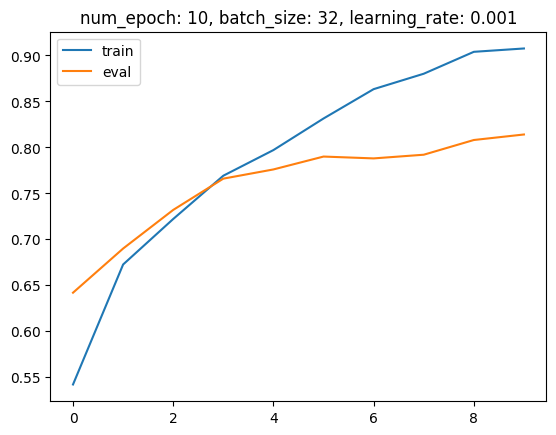

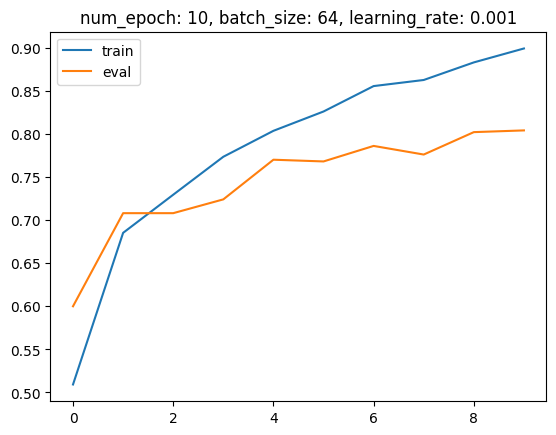

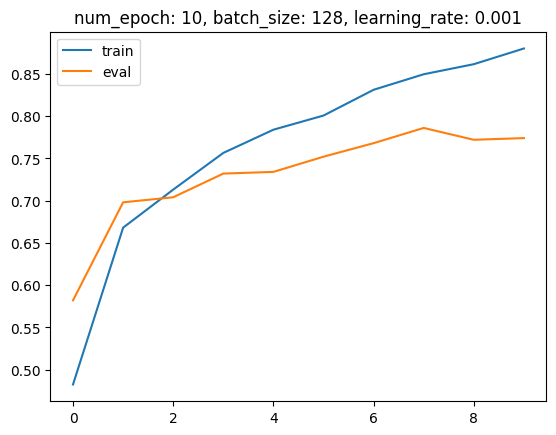

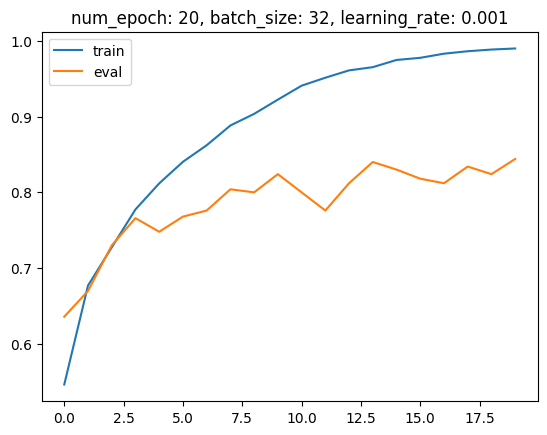

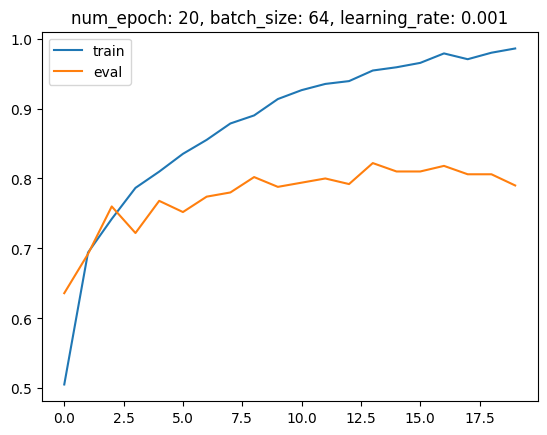

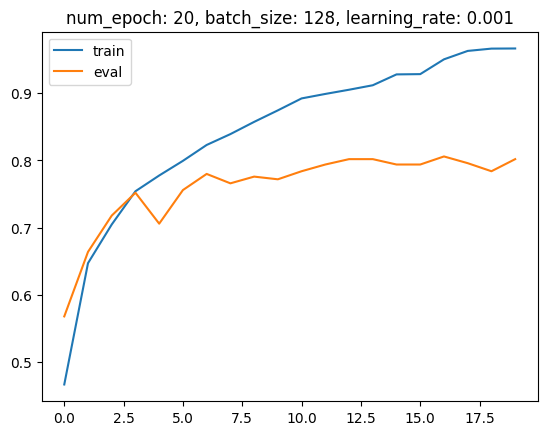

In [23]:
import matplotlib.pyplot as plt

# Plot the training and eval accuracies for each hyperparameter combination
for num_epoch in num_epochs:
    for batch_size in batch_sizes:
        for learning_rate in learning_rates:
            accuracy_callback = accuracies[(num_epoch, batch_size, learning_rate)]
            plt.plot(accuracy_callback.train_accuracies, label='train')
            plt.plot(accuracy_callback.eval_accuracies, label='eval')
            plt.title("num_epoch: {}, batch_size: {}, learning_rate: {}".format(num_epoch, batch_size, learning_rate))
            plt.legend()
            plt.show()

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'num_epoch: 10, batch_size: 32, learning_rate: 0.001'),
  Text(1, 0, 'num_epoch: 10, batch_size: 64, learning_rate: 0.001'),
  Text(2, 0, 'num_epoch: 10, batch_size: 128, learning_rate: 0.001'),
  Text(3, 0, 'num_epoch: 20, batch_size: 32, learning_rate: 0.001'),
  Text(4, 0, 'num_epoch: 20, batch_size: 64, learning_rate: 0.001'),
  Text(5, 0, 'num_epoch: 20, batch_size: 128, learning_rate: 0.001')])

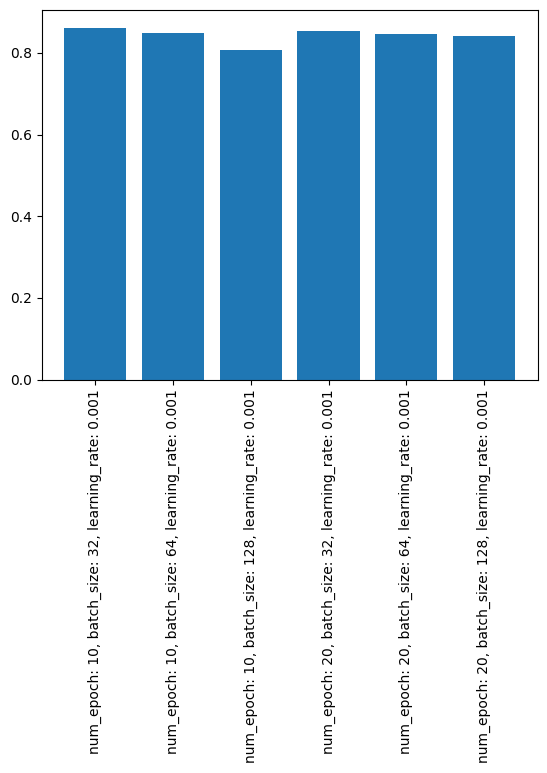

In [28]:
# Plot the test accuracies for each hyperparameter combination and label the x-axis accordingly
x_axis = []
y_axis = []
for num_epoch in num_epochs:
    for batch_size in batch_sizes:
        for learning_rate in learning_rates:
            x_axis.append("num_epoch: {}, batch_size: {}, learning_rate: {}".format(num_epoch, batch_size, learning_rate))
            y_axis.append(test_accuracy[(num_epoch, batch_size, learning_rate)])

# Make the x-axis labels vertical
plt.bar(x_axis, y_axis)
plt.xticks(rotation=90)